# Main Analysis Pipeline

In [1]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CyDetHits, CTHHits, CDCHits, FlatHits
from memory_profiler import memory_usage
from pprint import pprint
from collections import Counter
sys.path.insert(0, '../modules')
from root_numpy import list_branches
%load_ext memory_profiler
from tracking import HoughSpace
from scipy import sparse
from tracking import HoughTransformer, HoughShifter
from cylinder import CyDet

Populating the interactive namespace from numpy and matplotlib


# Convenience Functions

## Access data

In [2]:
def get_measurment_and_neighbours(hit_sample, measurement, events=None):
    """
    Get the measurement on the wire and its neighbours in a classification-friendly way
    
    :return: a list of three numpy arrays of measurement 1) on wire, 2) to left, 3) to right
    """
    return [hit_sample.get_measurement(measurement, 
                                       events, 
                                       shift=i, 
                                       only_hits=True, 
                                       flatten=True) 
                for i in [0,-1,1]] 

## Import the Signal Hits

In [3]:
def test_labelling(hit_sample, sig_name, momentum_name, value):
    current_labels = hit_sample.get_events()[sig_name]
    momentum_magnitude = np.sqrt(np.square(hit_sample.get_events()[momentum_name+'.fX']) +\
                                 np.square(hit_sample.get_events()[momentum_name+'.fY']) +\
                                 np.square(hit_sample.get_events()[momentum_name+'.fZ']))
    pid_values = hit_sample.get_events()[pid_name]
    new_labels = np.logical_and(momentum_magnitude > value, pid_values == 11)
    print "Number of signal now : {}".format(sum(current_labels))
    print "Number of signal actual : {}".format(sum(new_labels))
    print "Number mislabelled : {}".format(hit_sample.n_hits - sum(current_labels == new_labels))

In [4]:
def smear_all_times(hit_sample, smears):
    for branch in hit_sample.data.dtype.names:
        if (branch.endswith("fE") and branch.find("Pos")) \
            or branch.endswith("DetectedTime") \
            or branch.endswith("StartT"):
            print "Smearing Branch " + branch
            hit_sample.data[branch] += smears

In [5]:
def smear_times(cdc_samp, cth_samp, smear):
    assert cdc_samp.n_events == cth_samp.n_events, \
        "ERROR : CDC and CTH have different number of events!\n"+\
        "cdc_samp.n_events {}\n".format(cdc_samp.n_events)+\
        "cth_samp.n_events {}\n".format(cth_samp.n_events)
    random_time_smear = np.random.randint(-smear,smear, size=cdc_samp.n_events)
    cdc_time_smear = random_time_smear[cdc_samp.hits_to_events]
    cth_time_smear = random_time_smear[cth_samp.hits_to_events]
    smear_all_times(cdc_samp, cdc_time_smear)
    smear_all_times(cth_samp, cth_time_smear)

In [6]:
def import_signal(cdc_file, cth_file, emp_branches, import_branches,
                  low_bound, up_bound_cdc, up_bound_cth, smear):
    # Import cdc
    cdc_selection = "CDCHit.fDetectedTime < " + str(up_bound_cdc + smear) + \
                    "&& CDCHit.fDetectedTime > " + str(low_bound - smear)
    cdc_samp = CyDetHits(cdc_file, 
                          tree="CDCHitTree",
                          signal_coding=[1], 
                          hit_type_name=sig_flag,
                          row_name=row_name,
                          branches=import_branches,
                          empty_branches=emp_branches,
                          selection=cdc_selection)

    cdc_samp.data[cdc_samp.hit_type_name] = cdc_samp.data[track_id_name] == 1
    print "Number of CDC Events : " + str(cdc_samp.n_events)
    print "Number of CDC Hits : " + str(cdc_samp.n_hits)

    # Import CTH
    cth_selection = "CTHHit.fStartT < " + str(up_bound_cth + smear) + \
                    "&& CTHHit.fStartT > " + str(low_bound - smear)
    cth_samp = FlatHits(cth_file,
                      tree="CTHHitTree",
                      signal_coding=[1], 
                      hit_type_name=sig_flag,
                      prefix="CTHHit.f",
                      branches=["CTHHit.fStartT",
                                "CTHHit.fTrackID",
                                "CTHHit.fCharge"],
                      selection=cth_selection)
    print "Number of CTH Events : " + str(cth_samp.n_events)
    print "Number of CTH Hits : " + str(cth_samp.n_hits)
    
    passed_events = np.intersect1d(cth_samp.get_signal_hits()[cth_samp.key_name], 
                                   cdc_samp.get_signal_hits()[cdc_samp.key_name])
    cdc_samp.trim_hits(cdc_samp.key_name, values=passed_events)
    cth_samp.trim_hits(cth_samp.key_name, values=passed_events)
    cth_samp.sort_hits("CTHHit.fStartT")
    print "Number of events with both : " + str(len(passed_events))
    return cdc_samp, cth_samp

### Make cuts

In [7]:
def trim_cth_track(cth_samp):    
    # First reduce each CTH hit to the earliest signal hit in that track
    hits_to_keep = []
    for evt in range(cth_samp.n_events):
        sig_hits = cth_samp.get_signal_hits(evt)
        for track in np.unique(sig_hits["CTHHit.fTrackID"]):
            track_hits = cth_samp.filter_hits(sig_hits, "CTHHit.fTrackID", values=track)
            min_time = np.amin(track_hits["CTHHit.fStartT"])
            earliest_hit = track_hits[cth_samp.hits_index_name][track_hits["CTHHit.fStartT"] == min_time][0]
            #if earliest_hit != track_hits[cth_samp.hits_index_name][0]:
            #    print "time error"
            #    break
            #hits_to_keep.append(cth_samp.filter_hits(sig_hits, "CTHHit.fTrackID", values=track)[cth_samp.hits_index_name][0])
            hits_to_keep.append(earliest_hit)
            
    print "Before earliest track cut " + str(cth_samp.n_hits)
    cth_samp.trim_hits(cth_samp.hits_index_name, values=hits_to_keep)
    print "After earliest track cut " + str(cth_samp.n_hits)

In [8]:
def apply_timing_cut(cdc_samp, cth_samp, low_bound, up_bound_cdc, up_bound_cth):
    # Apply the timing filter
    print "Before timing cut"
    before_cdc_nhits = cdc_samp.n_hits
    before_cth_nhits = cth_samp.n_hits
    print "CTH Hits: {}".format(before_cth_nhits)
    print "CDC Hits: {}".format(before_cdc_nhits)
    cdc_samp.trim_hits(variable=cdc_samp.time_name, greater_than=low_bound, less_than=up_bound_cdc)
    cth_samp.trim_hits(variable="CTHHit.fStartT", greater_than=low_bound, less_than=up_bound_cth)
    print "After timing cut"
    print "CTH Hits: {0}, {1:.4f}".format(cth_samp.n_hits, float(cth_samp.n_hits)/before_cth_nhits)
    print "CDC Hits: {0}, {1:.4f}".format(cdc_samp.n_hits, float(cdc_samp.n_hits)/before_cdc_nhits)
    passed_events = np.intersect1d(cth_samp.get_events()[cth_samp.key_name], 
                               cdc_samp.get_events()[cdc_samp.key_name])
    cdc_samp.trim_hits(cdc_samp.key_name, values=passed_events)
    cth_samp.trim_hits(cth_samp.key_name, values=passed_events)
    print "Events left : " + str(len(passed_events))

In [9]:
def filter_cth_time_window(cth_samp):
    # Filter for CTH in time window.  Get the time
    trig_evts = []
    for evt in range(cth_samp.n_events):
        sig_hits = cth_samp.get_signal_hits(evt)
        if len(sig_hits) != 0:
            event_key = cth_samp.get_events(evt)[cth_samp.key_name]
            if len(np.unique(event_key)) != 1:
                print "key error"
                print event_key
                break
            else:
                trig_evts.append(event_key[0])
    trig_evts = np.array(trig_evts)
    print "Events that pass CTH Trigger: {}".format(len(trig_evts))
    return trig_evts

In [10]:
def max_layer_cut(cdc_samp):
    # Filter for max layer is five
    max_layer = []
    gd_max_lay = []
    for evt in range(cdc_samp.n_events):
        these_layers = cdc_samp.geom.point_layers[cdc_samp.get_sig_wires(evt)]
        this_key = cdc_samp.get_events(evt)[cdc_samp.key_name]
        if len(cdc_samp.get_sig_wires(evt)) != 0:
            if np.amax(these_layers) >= 4:
                if len(np.unique(this_key)) != 1:
                    print "key error"
                    print this_key
                    break
                else:
                    gd_max_lay.append(np.unique(this_key)[0])
    gd_max_lay = np.array(gd_max_lay)
    print "Passed Max Layer {}".format(len(gd_max_lay))
    return gd_max_lay

In [11]:
def min_hits_cut(cdc_samp):
    # Filter for number of signal hits
    n_signal_hits  = np.array([len(cdc_samp.get_signal_hits(evt)) 
                             for evt in range(cdc_samp.n_events)])
    n_signal_hits = np.array(n_signal_hits)
    good_n_hits = np.arange(cdc_samp.n_events)[n_signal_hits >= 30]
    good_n_hits = np.unique(cdc_samp.get_events(good_n_hits)[cdc_samp.key_name])
    print "Passed Good Number of Hits : {}".format(len(good_n_hits))
    return good_n_hits

In [12]:
def combine_all_cuts(orig_evts, trig_evts, lay_evts, nhits_evts):
    pass_events = np.intersect1d(orig_evts, trig_evts)
    print "Removed due to CTH Trigger {}".format(len(orig_evts) - len(trig_evts))
    pass_events = np.intersect1d(pass_events, lay_evts)
    print "Removed due to Layer Cut {}".format(len(orig_evts)  - len(lay_evts))
    pass_events = np.intersect1d(pass_events, nhits_evts)
    print "Removed due to N Hits Cut {}".format(len(orig_evts) - len(nhits_evts))
    print "After All Cuts {}".format(len(pass_events))
    return pass_events

### Import Files with Cuts

In [13]:
def import_signal_with_cuts(cdc_file, cth_file, emp_branches, import_branches,
                            low_bound, up_bound_cdc, up_bound_cth, smear):
    # Import the samples
    cdc_samp, cth_samp = import_signal(cdc_file, cth_file, emp_branches, import_branches,
                                       low_bound, up_bound_cdc, up_bound_cth, smear)
    # Smear the times to include bunch width
    smear_times(cdc_samp, cth_samp, smear)
    # Trim back the CTH hits to only be one per track per particle
    #trim_cth_track(cth_samp)
    # Trim back the hits in both samples to the fiducial time window
    apply_timing_cut(cdc_samp, cth_samp, low_bound, up_bound_cdc, up_bound_cth)
    # Only keep CTH events that have hits (should be all)
    trigger_events = filter_cth_time_window(cth_samp)
    # Only include the events which get into a certain layer
    good_max_layer = max_layer_cut(cdc_samp)
    # Only include events with the minimun number of allowed hits
    good_n_hits=  min_hits_cut(cdc_samp)
    # Get the hits we still have
    original_events = np.intersect1d(cth_samp.get_events()[cth_samp.key_name], 
                                     cdc_samp.get_events()[cdc_samp.key_name])
    passed_events = combine_all_cuts(original_events, trigger_events, good_max_layer, good_n_hits)
    # Trim the samples to only these events
    cdc_samp.trim_hits(cdc_samp.key_name, values=passed_events)
    cth_samp.trim_hits(cth_samp.key_name, values=passed_events)
    return cdc_samp, cth_samp

In [14]:
def import_backgroud(back_file, emp_branches, import_branches, low_bound, up_bound_cdc):
    cdc_selection = "CDCHit.fDetectedTime < " + str(up_bound_cdc) + \
                    "&& CDCHit.fDetectedTime > " + str(low_bound)
    back_sample = CyDetHits(back_file, 
                         signal_coding=[1], 
                         row_name=row_name,
                         hit_type_name=sig_flag,
                         branches=import_branches,
                         empty_branches=emp_branches,
                         selection=cdc_selection)
    # Apply the timing filter
    print "Back Events : {}".format(back_sample.n_events)
    print "CyDet Hits: {}".format(back_sample.n_hits)
    back_sample.trim_hits(variable=back_sample.time_name, greater_than=low_bound, less_than=up_bound_cdc)
    print "CyDet Hits: {}".format(back_sample.n_hits)
    print "Back Events : {}".format(back_sample.n_events)
    return back_sample

### Finalize Sample

In [15]:
def add_in_signal(back_sample, cdc_sig_samp, cth_sig_samp):
    n_events = min(back_sample.n_events, cdc_sig_samp.n_events)
    print "Signal hits in signal sample " + str(len(cdc_sig_samp.get_signal_hits()))
    print "Background hits in signal sample " + str(len(cdc_sig_samp.get_background_hits()))
    print "Signal hits in background sample " + str(len(back_sample.get_signal_hits()))
    print "Background hits in Background sample " + str(len(back_sample.get_background_hits()))
    back_sample.trim_events(range(n_events))
    cdc_sig_samp.trim_events(range(n_events))
    cth_sig_samp.trim_events(range(n_events))
    hits_samp = back_sample
    hits_samp.add_hits(cdc_sig_samp.data)
    return hits_samp, cth_sig_samp

In [16]:
def set_additional_branches(hits_samp, cth_samp):
    # Set the Layer Value and Cell ID value
    hits_samp.data[hits_samp.row_name] = hits_samp.geom.point_layers[hits_samp.get_events()[hits_samp.flat_name]]
    hits_samp.data[cell_id_name] = hits_samp.geom.point_indexes[hits_samp.get_events()[hits_samp.flat_name]]
    # Set the trigger times
    for evt in range(hits_samp.n_events):
        sig_hits = cth_samp.get_signal_hits(evt)
        if len(sig_hits) != 0:
            this_trig_time = np.amin(sig_hits["CTHHit.fStartT"])
            hits_samp.data[hits_samp.trig_name][hits_samp.event_to_hits[evt]] = this_trig_time
    # Set the relative timing
    hits_samp.data[rel_time_name] = hits_samp.data[hits_samp.time_name] - hits_samp.data[hits_samp.trig_name]

### Import Sample Directly

In [17]:
def import_hits_sample(cdc_file, cth_file, back_file, 
                       emp_branches, import_branches,
                       lower_time, upper_time_cdc, upper_time_cth, smear):
    print "Memory Usage {}".format(memory_usage())
    print "Imporing Signal Files : \n{}\n{}".format(cdc_file, cth_file)
    cdc_samp, cth_samp = import_signal_with_cuts(cdc_file, cth_file, 
                                                 emp_branches, import_branches,
                                                 lower_time, upper_time_cdc, upper_time_cth, smear)
    print "Memory Usage {}".format(memory_usage())
    print "\nImporing Background Files : \n{}".format(back_file)
    back_samp = import_backgroud(back_file, 
                                 emp_branches, import_branches, 
                                 lower_time, upper_time_cdc)
    print "Memory Usage {}".format(memory_usage())
    print "\nAdding in the signal sample to the background sample"
    hits_samp, cth_samp = add_in_signal(back_samp, cdc_samp, cth_samp)
    print "Memory Usage {}".format(memory_usage())
    print "\nSetting additional branches"
    set_additional_branches(hits_samp, cth_samp)
    print "\nDone!"
    print "Memory Usage {}".format(memory_usage())
    return hits_samp

## Define Our Samples

In [18]:
file_base = "/vols/comet/users/elg112/ICEDUST"\
            "/local_storage/Blessed_Outputs"\
            "/335e4_"
cdc_sig_file = file_base + "cdc_signal.root"
cth_sig_file = file_base + "cth_signal.root"

In [19]:
file_base = "/vols/comet/users/elg112/ICEDUST"\
            "/local_storage/Blessed_Outputs"\
            "/2e5_"
cdc_sig_file = file_base + "cdc_signal.root"
cth_sig_file = file_base + "cth_signal.root"

In [20]:
file_base = "/vols/comet/users/elg112/ICEDUST"\
            "/local_storage/Blessed_Outputs"\
            "/2e5_"
cdc_sig_file = file_base + "cdc_signal_xtcurve.root"
cth_sig_file = file_base + "cth_signal_xtcurve.root"

In [36]:
file_base = "/vols/comet/users/elg112/ICEDUST"\
            "/local_storage/Blessed_Outputs/"
cdc_sig_file = file_base + "250k_combined_signal_batch_1.root"
cth_sig_file = cdc_sig_file

In [37]:
back_sample_root = "/vols/comet/users/elg112/ICEDUST"\
                   "/local_storage/Blessed_Outputs/"
cdc_back_file = back_sample_root + "4_2536_cdc_back.root"

In [38]:
# Define some branches to import
## Existing branches
prefix = "CDCHit.f"
drift_name = prefix + "DriftTime"
track_id_name = prefix + "Track.fTrackID"

## Branches not needed
drift_dist_name = prefix + "DriftDist"
turn_id_name = prefix + "TurnID"
pid_name = prefix + "Track.fPID"
parent_track_id_name = prefix + "Track.fParentTrackID"
all_momentum_names = [ prefix + "Track.f" + st_sp + "Momentum.f" + coor 
                       for st_sp in ["Start", "Stop"] for coor in ["X", "Y", "Z"] ]
all_pos_names = [ prefix + "Track.f" + st_sp + "PosGlobal.f" + coor 
                       for st_sp in ["Start", "Stop"] for coor in ["P.fX", "P.fY", "P.fZ", "E"] ]
hit_pos_names = [ prefix + "MCPos.f" + coor for coor in ["P.fX", "P.fY", "P.fZ", "E"] ]
hit_mom_names = [ prefix + "MCMom.f" + coor for coor in ["X", "Y", "Z"] ]


## Branches to be filled
row_name = "Layers"
cell_id_name = prefix + "CellID"
lcl_scr_name = prefix + "Local_Score"
ngh_scr_name = prefix + "Neigh_Score"
hgh_scr_name = prefix + "Hough_Score"
trk_scr_name = prefix + "Track_Score"
rel_time_name = prefix + "Relative_Time"
take_hit_name = prefix + "Take_Hit"
## Kinda both
sig_flag = "IsSig"

In [39]:
these_branches = [drift_name, 
                  track_id_name ]

## For track fitting
#these_branches += [turn_id_name, 
#                   drift_dist_name,
#                   pid_name,
#                   parent_track_id_name] +\
#                  hit_mom_names +\
#                  all_momentum_names +\
#                  all_pos_names +\
#                  hit_pos_names
                
empty_branches = [prefix + row_name, 
                  cell_id_name,
                  lcl_scr_name, 
                  ngh_scr_name, 
                  hgh_scr_name,
                  trk_scr_name, 
                  rel_time_name,
                  take_hit_name]

## Import the Data

In [40]:
lower_bound_time= 700
upper_bound_time_cdc = 1620
upper_bound_time_cth = 1170
time_smear = 50

In [41]:
train_cdc = import_hits_sample(cdc_sig_file, cth_sig_file, cdc_back_file, empty_branches, these_branches, lower_bound_time, upper_bound_time_cdc, upper_bound_time_cth, time_smear)

Memory Usage [278.91796875]
Imporing Signal Files : 
/vols/comet/users/elg112/ICEDUST/local_storage/Blessed_Outputs/250k_combined_signal_batch_1.root
/vols/comet/users/elg112/ICEDUST/local_storage/Blessed_Outputs/250k_combined_signal_batch_1.root


TClass::TClass:0: RuntimeWarning: no dictionary for class COMET::ICOMETEvent is available
TClass::TClass:0: RuntimeWarning: no dictionary for class COMET::IDataVector is available
TClass::TClass:0: RuntimeWarning: no dictionary for class COMET::IData is available
TClass::TClass:0: RuntimeWarning: no dictionary for class COMET::IDatum is available
TClass::TClass:0: RuntimeWarning: no dictionary for class COMET::ICOMETContext is available
TClass::TClass:0: RuntimeWarning: no dictionary for class COMET::ISHAHashValue is available
TClass::TClass:0: RuntimeWarning: no dictionary for class COMET::IAlignmentId is available
TClass::TClass:0: RuntimeWarning: no dictionary for class COMET::ICOMETEvent::Header is available


Number of CDC Events : 107847
Number of CDC Hits : 5769836
Number of CTH Events : 80333
Number of CTH Hits : 22291623
Number of events with both : 30313
Smearing Branch CDCHit.fDetectedTime
Smearing Branch CTHHit.fStartT
Before timing cut
CTH Hits: 15419989
CDC Hits: 2556724
After timing cut
CTH Hits: 12648756, 0.8203
CDC Hits: 2492531, 0.9749
Events left : 26300
Events that pass CTH Trigger: 24871
Passed Max Layer 21569
Passed Good Number of Hits : 22890
Removed due to CTH Trigger 1429
Removed due to Layer Cut 4731
Removed due to N Hits Cut 3410
After All Cuts 20060
Memory Usage [1513.94140625]

Imporing Background Files : 
/vols/comet/users/elg112/ICEDUST/local_storage/Blessed_Outputs/4_2536_cdc_back.root
Back Events : 2536
CyDet Hits: 1430015
CyDet Hits: 1430015
Back Events : 2536
Memory Usage [1837.6796875]

Adding in the signal sample to the background sample
Signal hits in signal sample 1941110
Background hits in signal sample 14951
Signal hits in background sample 0
Background h

## Prepare the data

In [42]:
bins_for_plots = 50
figsize(10,5)

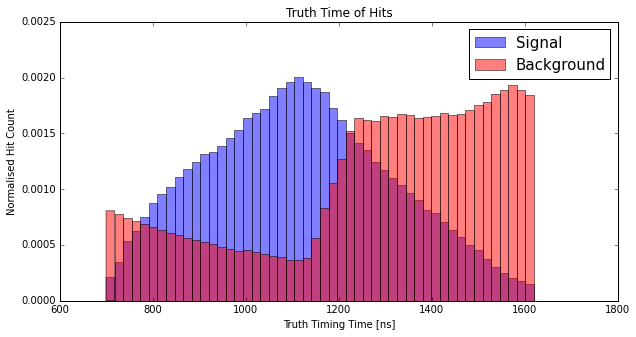

In [43]:
plot_feature( train_cdc.get_signal_hits()[train_cdc.time_name], 
              train_cdc.get_background_hits()[train_cdc.time_name], 
              xlabel="Detected Time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Detected Time of Hits", 
              nbins=bins_for_plots)
show()

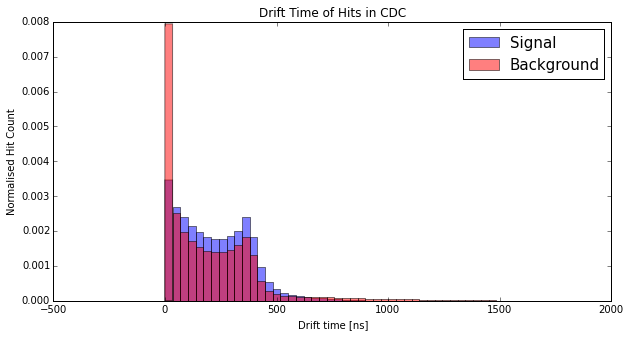

In [44]:
plot_feature( train_cdc.get_signal_hits()[drift_name], 
              train_cdc.get_background_hits()[drift_name], 
              xlabel="Drift time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Drift Time of Hits in CDC", 
              nbins=bins_for_plots)
show()

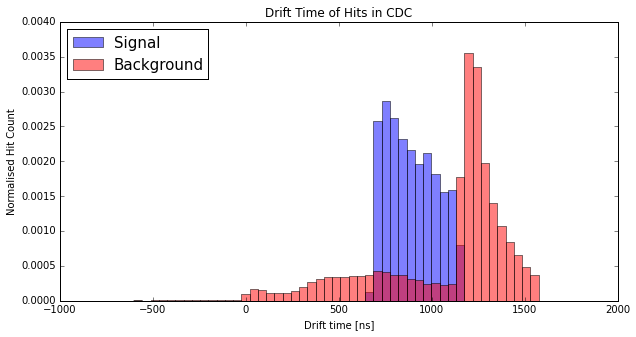

In [45]:
plot_feature( train_cdc.get_signal_hits()[train_cdc.time_name] -\
              train_cdc.get_signal_hits()[drift_name],  
              train_cdc.get_background_hits()[train_cdc.time_name] -\
              train_cdc.get_background_hits()[drift_name], 
              xlabel="Truth time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Truth Time of Hits in CDC",  
              nbins=bins_for_plots)
show()

# Begin the Analysis

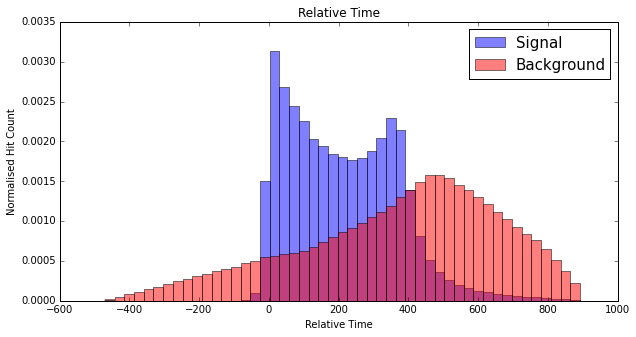

In [46]:
plot_feature( train_cdc.get_signal_hits()[rel_time_name], 
              train_cdc.get_background_hits()[rel_time_name], 
              xlabel="Relative Time", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Relative Time", 
              nbins=bins_for_plots)
show()

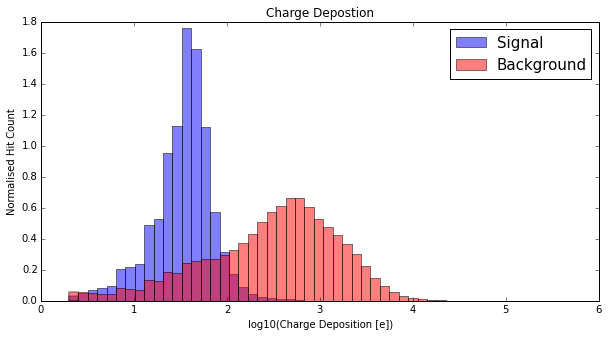

In [47]:
plot_feature( np.log10(train_cdc.get_signal_hits()[train_cdc.edep_name] + 1), 
              np.log10(train_cdc.get_background_hits()[train_cdc.edep_name] + 1), 
              xlabel="log10(Charge Deposition [e])", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Charge Depostion", 
              nbins=bins_for_plots)
show()

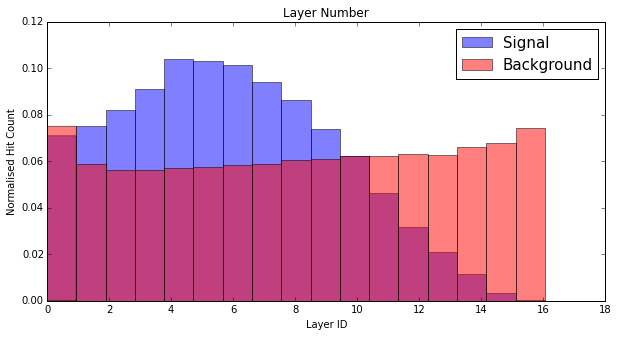

In [48]:
plot_feature( train_cdc.get_signal_hits()[train_cdc.row_name], 
              train_cdc.get_background_hits()[train_cdc.row_name], 
              xlabel="Layer ID", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Layer Number", 
              nbins=18)
show()

In [49]:
sig_occupancy = []
back_occupancy = []
occupancy = []

for event in range(train_cdc.n_events):
    sig_occupancy += [len(np.unique(train_cdc.get_signal_hits(event)[train_cdc.flat_name]))]
    back_occupancy += [len(np.unique(train_cdc.get_background_hits(event)[train_cdc.flat_name]))]
    occupancy += [len(np.unique(train_cdc.get_events(event)[train_cdc.flat_name]))]    

In [50]:
avg_n_hits = np.average(train_cdc.event_to_n_hits)
avg_n_hits = np.average(train_cdc.event_to_n_hits)
avg_occ = np.average(occupancy)
print np.average(sig_occupancy), np.average(back_occupancy)

print avg_occ, avg_occ/4482
print avg_n_hits, (avg_n_hits - avg_occ)/float(avg_occ)

75.3939274448 500.787066246
567.376182965 0.126589956039
662.313091483 0.167326213838


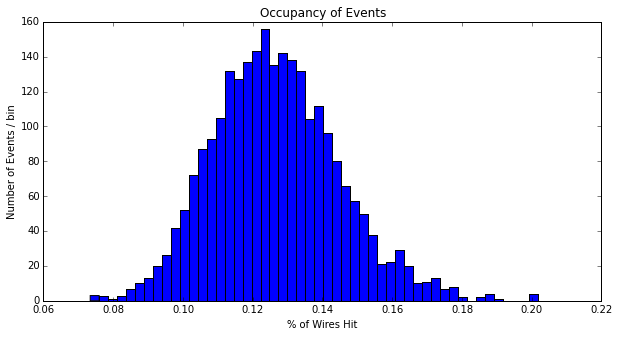

In [51]:
plt.title("Occupancy of Events")
plt.xlabel("% of Wires Hit")
plt.ylabel("Number of Events / bin")
plt.hist(np.array(occupancy)/4482., bins=50)
plt.show()

## Local Classification : Deal with Coincidence

### Make training/testing splits

In [52]:
def reset_masks(evt_samp, hit_sample):
    total_events = hit_sample.n_events
    total_hits = hit_sample.n_hits

    evt_samp_masks = [ np.zeros(total_events, dtype=bool) for samp in evt_samp ]
    hit_masks      = [ np.zeros(total_hits, dtype=bool) for samp in evt_samp ]
    for i in range(len(evt_samp)):
        evt_samp_masks[i][evt_samp[i]] = True
        hit_masks[i][hit_sample.get_events(evt_samp[i])[hit_sample.hits_index_name]] = True
    return evt_samp_masks, hit_masks

In [53]:
def remove_coincidence(hit_samp):
    print "Hits before coincidence removal : {}".format(hit_samp.n_hits)
    # Sort events by channel, by score
    hit_samp.sort_hits([hit_samp.flat_name, lcl_scr_name])
    # Recored which hit have the best score by event by channel
    all_hits_to_take = []
    # Stats about hit removal
    removal_stats = {"is_sig, more_sig"    : 0,
                     "is_sig, no_more_sig" : 0,
                     "not_sig, more_sig"    : 0,
                     "not_sig, no_sig"      : 0}

    # Loop over all events
    for evt in range(hit_samp.n_events):
        event_hits = hit_samp.get_events(evt)
        for channel in np.unique(event_hits[hit_samp.flat_name]):
            chan_hits = hit_samp.filter_hits(event_hits, hit_samp.flat_name, channel)
            this_chan_hit = chan_hits[hit_samp.hits_index_name][-1]
            all_hits_to_take.append(this_chan_hit)
            # Check for coincidence
            if len(chan_hits) > 1:
                # Check the channel content
                is_sig = hit_samp.data[this_chan_hit][hit_samp.hit_type_name] == 1
                # Check if there was more signal
                has_more_sig = (sum(chan_hits[hit_samp.hit_type_name] == 1) - is_sig) > 0
                # Check which hit we chose
                if is_sig and has_more_sig:
                    removal_stats["is_sig, more_sig"] += 1
                elif is_sig and not has_more_sig:
                    removal_stats["is_sig, no_more_sig"] += 1
                elif not is_sig and has_more_sig:
                    removal_stats["not_sig, more_sig"] += 1
                else:
                    removal_stats["not_sig, no_sig"] += 1
    pprint(removal_stats)
    print sum(hit_samp.get_events()["CDCHit.fIsSig"])
    print sum(removal_stats.values())

    # Make a mask
    chan_hit_mask = np.zeros(hit_samp.n_hits, dtype=bool)
    chan_hit_mask[all_hits_to_take] = 1
    # Set the hits to take as channel hit
    hit_samp.data[take_hit_name][chan_hit_mask] = 1
    # Trim the hits we are not going to look at
    hit_samp.trim_hits(take_hit_name, values=1)
    hit_samp.sort_hits(hit_samp.flat_name)
    print "Hits after coincidence removal : {}".format(hit_samp.n_hits)

In [54]:
# Split up the data first
from sklearn.cross_validation import train_test_split

# Seed for sample mixing
seed = 10

# Get samples
rest = range(train_cdc.n_events)
rest, sample_3     = train_test_split(rest, train_size=0.54, test_size=0.36, random_state=seed)
sample_1, sample_2 = train_test_split(rest, train_size=0.33, test_size=0.66, random_state=seed)

# Get event masks
evt_samp       = [ sample_1, sample_2, sample_3 ]
evt_samp_masks, hit_masks = reset_masks(evt_samp, train_cdc)

### Classify Using Local Features

In [55]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier, TMVAClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc
from pandas import DataFrame
from sklearn.metrics import roc_auc_score, roc_curve

In [56]:
# Define Data
lcl_train_features = [train_cdc.edep_name, rel_time_name, train_cdc.row_name]

In [57]:
factory = ClassifiersFactory()

# Define GBDT over neighbour-level features
local_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=lcl_train_features)
# Add the GBDT
factory.add_classifier('Local Features', local_gbdt)

In [58]:
# Train the classifier
factory.fit(DataFrame(train_cdc.data[lcl_train_features][hit_masks[0]]), 
            train_cdc.data[train_cdc.hit_type_name][hit_masks[0]])
pass

model Local Features was trained in 33.49 seconds
Totally spent 33.49 seconds on training


In [59]:
train_cdc.print_branches()

Branches available are:
CDCHit.fDriftTime
CDCHit.fTrack.fTrackID
CDCHit.fEventNumber
CDCHit.fhits_index
CDCHit.fevent_index
CDCHit.fCellID
CDCHit.fHough_Score
CDCHit.fIsSig
CDCHit.fLayers
CDCHit.fLocal_Score
CDCHit.fNeigh_Score
CDCHit.fRelative_Time
CDCHit.fTake_Hit
CDCHit.fTrack_Score
CDCHit.fTrigTime
CDCHit.fvol_id
CDCHit.fCharge
CDCHit.fDetectedTime


In [60]:
# Print these predictions
train_cdc.data[lcl_scr_name] = local_gbdt.predict_proba(DataFrame(train_cdc.data[lcl_train_features]))[:,1]
# Invalidate the training sample
train_cdc.data[lcl_scr_name][hit_masks[0]] = -1
# remove the coincidence
remove_coincidence(train_cdc)
# Reset the sample masks
evt_samp_masks, hit_masks = reset_masks(evt_samp, train_cdc)

Hits before coincidence removal : 1679626
{'is_sig, more_sig': 37799,
 'is_sig, no_more_sig': 15878,
 'not_sig, more_sig': 2073,
 'not_sig, no_sig': 133011}
247830
188761
Hits after coincidence removal : 1438866


0.98180805491


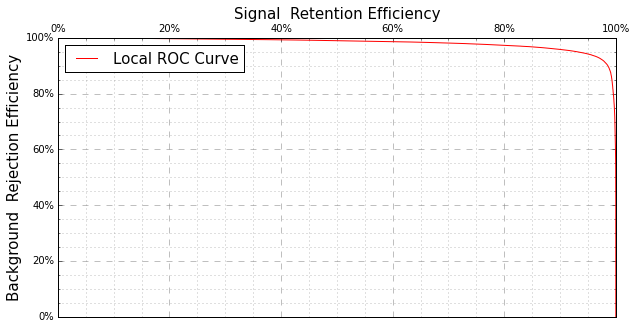

In [61]:
plot_roc_curve(train_cdc.data[train_cdc.hit_type_name][np.logical_not(hit_masks[0])], 
               train_cdc.data[lcl_scr_name][np.logical_not(hit_masks[0])], 
               zoom=False, label="Local ROC Curve")
print roc_auc_score(train_cdc.data[train_cdc.hit_type_name][np.logical_not(hit_masks[0])], 
               train_cdc.data[lcl_scr_name][np.logical_not(hit_masks[0])])
plt.show()

## Use Neighbour Level Features

In [62]:
# Define Data
neigh_train_features = [train_cdc.edep_name, 
                        train_cdc.edep_name + "_left",
                        train_cdc.edep_name + "_right",
                        rel_time_name, 
                        rel_time_name + "_left",
                        rel_time_name + "_right",
                        train_cdc.row_name]

In [63]:
# Define GBDT over neighbour-level features
neigh_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=neigh_train_features)
# Add the GBDT
factory.add_classifier('Neighbour and Local Features', neigh_gbdt)

In [64]:
# Train the classifier
factory.fit(DataFrame(
                np.vstack(
                    get_measurment_and_neighbours(train_cdc, train_cdc.edep_name, evt_samp[1]) +\
                    get_measurment_and_neighbours(train_cdc, train_cdc.time_name, evt_samp[1]) +\
                    [train_cdc.data[train_cdc.row_name][hit_masks[1]]]).T,
                columns=neigh_train_features), 
            train_cdc.data[train_cdc.hit_type_name][hit_masks[1]])
pass

model Local Features was trained in 67.86 seconds
model Neighbour and Local Features was trained in 128.25 seconds
Totally spent 196.11 seconds on training


In [65]:
# Print these predictions
train_cdc.data[ngh_scr_name] = neigh_gbdt.predict_proba(
    DataFrame(
        np.vstack(
            get_measurment_and_neighbours(train_cdc, train_cdc.edep_name) +\
            get_measurment_and_neighbours(train_cdc, train_cdc.time_name) +\
            [train_cdc.data[train_cdc.row_name]]).T,
        columns=neigh_train_features))[:,1]
# Invalidate the training sample
train_cdc.data[ngh_scr_name][np.logical_or(hit_masks[0], hit_masks[1])] = -1

0.990757504602


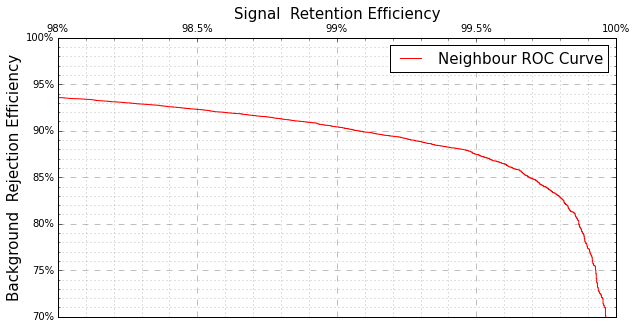

In [66]:
plot_roc_curve(train_cdc.data[train_cdc.hit_type_name][hit_masks[2]], 
               train_cdc.data[ngh_scr_name][hit_masks[2]], 
               zoom=True, label="Neighbour ROC Curve")
print roc_auc_score(train_cdc.data[train_cdc.hit_type_name][hit_masks[2]], 
               train_cdc.data[ngh_scr_name][hit_masks[2]])
plt.show()

In [67]:
# Define which wires we want to correct as hits which were missclassified 
problem_weights_2 = abs(train_cdc.data[train_cdc.hit_type_name][hit_masks[2]]
                        - train_cdc.data[ngh_scr_name][hit_masks[2]]) ** 2

In [68]:
print roc_auc_score(train_cdc.data[train_cdc.hit_type_name][hit_masks[2]], 
                    train_cdc.data[ngh_scr_name][hit_masks[2]])
print roc_auc_score(train_cdc.data[train_cdc.hit_type_name][hit_masks[2]], 
                    train_cdc.data[ngh_scr_name][hit_masks[2]],
                    sample_weight=problem_weights_2)

0.990757504602
0.212407494562


In [69]:
default = [[31.5, 34, 34.5, 2]]
submatrices = []

# TODO test with several radii
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = HoughSpace(CyDet(), sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                       sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81)
    corresp = hough.correspondence
    submatrices.append(corresp)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [70]:
# Fit and transform the second data sample
hough_transformer = HoughTransformer(new_correspondence, \
                                     hough.norm_track_neighs,\
                                     train_cdc.get_measurement(ngh_scr_name,
                                                              events=evt_samp[2],
                                                              only_hits=False,
                                                              flatten=False),
                                     alpha_max=2., alpha_rw=2.)

In [71]:
# Get the hough results
#hough_score, hough_images = \
train_cdc.data[hgh_scr_name], hough_images = \
        hough_transformer.transform(train_cdc.get_measurement(ngh_scr_name, 
                                                             only_hits=False, 
                                                             flatten=False),
                                   only_hits=True, flatten=True)

In [72]:
# Add this to the feature list
track_train_features = neigh_train_features + [hgh_scr_name]

# Define the new classifier
hough_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=track_train_features) 

# Define GBDT over only energy deposit to compare
dep_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                               features=[train_cdc.edep_name])

# Ensure neigh-level GBDT has enough trees to compare properly
neigh_gbdt.set_params(n_estimators=200)
local_gbdt.set_params(n_estimators=200)

# Add the classifiers
factory.add_classifier('Track, Local and Neighbour Features', hough_gbdt)
factory.add_classifier('Energy Deposition', dep_gbdt)

In [73]:
# Train the classifier
factory.fit(DataFrame(
                np.vstack(
                    get_measurment_and_neighbours(train_cdc, train_cdc.edep_name, evt_samp[2]) +\
                    get_measurment_and_neighbours(train_cdc, train_cdc.time_name, evt_samp[2]) +\
                    [train_cdc.data[train_cdc.row_name][hit_masks[2]]] +\
                    [train_cdc.data[hgh_scr_name][hit_masks[2]]]).T,
                columns=track_train_features), 
            train_cdc.data[train_cdc.hit_type_name][hit_masks[2]])
pass

model Local Features was trained in 138.53 seconds
model Neighbour and Local Features was trained in 257.31 seconds
model Track, Local and Neighbour Features was trained in 137.76 seconds
model Energy Deposition was trained in 76.15 seconds
Totally spent 609.76 seconds on training


## Save the Classifiers and Training Data

In [74]:
# Save the training sample and training data
import cPickle as pickle

In [75]:
# Choose directory to save it to
classifiers_dir = "/vols/comet/users/elg112/ICEDUST/track-finding-yandex/classifiers/"
train_name = "batch_4_2536"
test_name = "batch_3_2500"
save_class = True
load_class = False

In [76]:
if save_class:
    # Save the classifier
    pickle.dump(factory, open(classifiers_dir + "class_"+train_name+".p", "wb" ) )
    # Save the transformer 
    pickle.dump(hough_transformer, open(classifiers_dir + "hough_"+train_name+".p", "wb" ))
    # Save the training sample and remove it
    pickle.dump(train_cdc, open(classifiers_dir + "train_"+train_name+".p", "wb" ) )

In [77]:
print "Memory Usage {}".format(memory_usage())
%xdel train_cdc
print "Memory Usage {}".format(memory_usage())

Memory Usage [1368.71484375]
Memory Usage [1043.921875]


In [61]:
if load_class:
    factory = pickle.load(open(classifiers_dir + "class_"+train_name+".p", "rb" ) )
    hough_transformer = pickle.load(open(classifiers_dir + "hough_"+train_name+".p", "rb" ) )

In [78]:
print "Memory Usage {}".format(memory_usage())

Memory Usage [1043.921875]


## Test on the New Sample

In [79]:
## For track fitting
these_branches = [drift_name, 
                  track_id_name]

these_branches += [turn_id_name, 
                   drift_dist_name,
                   pid_name,
                   parent_track_id_name] +\
                  hit_mom_names +\
                  all_momentum_names +\
                  all_pos_names +\
                  hit_pos_names

In [97]:
these_branches = [drift_name, 
                  track_id_name ]

## For track fitting
#these_branches += [turn_id_name, 
#                   drift_dist_name,
#                   pid_name,
#                   parent_track_id_name] +\
#                  hit_mom_names +\
#                  all_momentum_names +\
#                  all_pos_names +\
#                  hit_pos_names
                
empty_branches = [prefix + row_name, 
                  cell_id_name,
                  lcl_scr_name, 
                  ngh_scr_name, 
                  hgh_scr_name,
                  trk_scr_name, 
                  rel_time_name,
                  take_hit_name]

In [98]:
file_base = "/vols/comet/users/elg112/ICEDUST"\
            "/local_storage/Blessed_Outputs/"
cdc_sig_file = file_base + "250k_combined_signal_batch_1.root"
cth_sig_file = cdc_sig_file

In [99]:
file_base = "/vols/comet/users/elg112/ICEDUST"\
            "/local_storage/Blessed_Outputs/"
cdc_sig_file = file_base + "250k_combined_signal_batch_2.root"
cth_sig_file = cdc_sig_file

In [100]:
back_sample_root = "/vols/comet/users/elg112/ICEDUST"\
                   "/local_storage/Blessed_Outputs/"
cdc_back_file = back_sample_root + "3_2500_cdc_back.root"

In [101]:
import hits
reload(hits)
from hits import CyDetHits

In [102]:
test_cdc = import_hits_sample(cdc_sig_file, cth_sig_file, cdc_back_file,
                              empty_branches, these_branches,
                              lower_bound_time, upper_bound_time_cdc, 
                              upper_bound_time_cth, time_smear)

Memory Usage [1368.13671875]
Imporing Signal Files : 
/vols/comet/users/elg112/ICEDUST/local_storage/Blessed_Outputs/250k_combined_signal_batch_2.root
/vols/comet/users/elg112/ICEDUST/local_storage/Blessed_Outputs/250k_combined_signal_batch_2.root
Number of CDC Events : 107336
Number of CDC Hits : 5728687
Number of CTH Events : 75988
Number of CTH Hits : 21091159
Number of events with both : 28624
Smearing Branch CDCHit.fDetectedTime
Smearing Branch CTHHit.fStartT
Before timing cut
CTH Hits: 14581336
CDC Hits: 2422053
After timing cut
CTH Hits: 11967164, 0.8207
CDC Hits: 2362195, 0.9753
Events left : 24757
Events that pass CTH Trigger: 23496
Passed Max Layer 20451
Passed Good Number of Hits : 21673
Removed due to CTH Trigger 1261
Removed due to Layer Cut 4306
Removed due to N Hits Cut 3084
After All Cuts 19114
Memory Usage [2232.71875]

Imporing Background Files : 
/vols/comet/users/elg112/ICEDUST/local_storage/Blessed_Outputs/3_2500_cdc_back.root
Back Events : 2499
CyDet Hits: 1414722

In [103]:
if save_class:
    # Save the test_sample
    pickle.dump(test_cdc, open(classifiers_dir + "test_"+test_name+".p", "wb" ) )

In [106]:
for event in range(test_cdc.n_events):
    event_name_cdc = np.unique(test_cdc.get_events(event)[test_cdc.key_name])
    sig_cdc = test_cdc.get_signal_hits(event)
    if (sum(sig_cdc[rel_time_name] < -100)) > 0:
        print event, event_name_cdc, event_name_cth
        print np.unique(sig_cth["CTHHit.fStartT"])
        print sig_cdc["CDCHit.fMCPos.fE"]

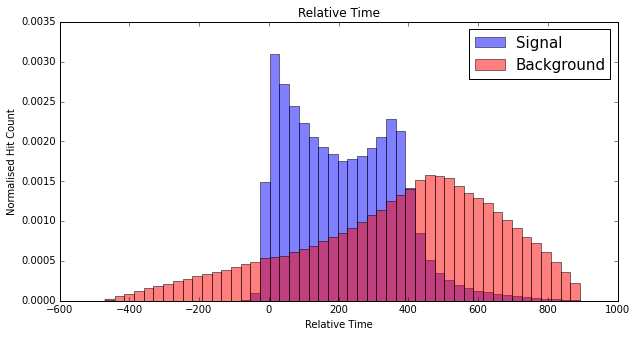

In [107]:
bins_for_plots = 50
plot_feature( test_cdc.get_signal_hits()[rel_time_name], 
              test_cdc.get_background_hits()[rel_time_name], 
              xlabel="Relative Time", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Relative Time", 
              nbins=bins_for_plots)
show()

In [108]:
#test_labelling(test_cdc,"CDCHit.fIsSig", "CDCHit.fTrack.fStartMomentum", 70)
#print test_cdc.n_hits

In [109]:
# Get the local score predictions
test_cdc.data[lcl_scr_name] = local_gbdt.predict_proba(DataFrame(test_cdc.data[lcl_train_features]))[:,1]
# Remove coincident hits
remove_coincidence(test_cdc)
# Get the neighbouring score predictions
test_cdc.data[ngh_scr_name] = neigh_gbdt.predict_proba(
    DataFrame(
        np.vstack(
            get_measurment_and_neighbours(test_cdc, test_cdc.edep_name) +\
            get_measurment_and_neighbours(test_cdc, test_cdc.time_name) +\
            [test_cdc.data[test_cdc.row_name]]).T,
        columns=neigh_train_features))[:,1]
# Get the hough results
test_cdc.data[hgh_scr_name], hough_images = \
        hough_transformer.transform(test_cdc.get_measurement(ngh_scr_name, 
                                                             only_hits=False, 
                                                             flatten=False),
                                   only_hits=True, flatten=True)
# Test it on the last set of data
test_cdc.data[trk_scr_name] = hough_gbdt.predict_proba(
        DataFrame(
            np.vstack(
                    get_measurment_and_neighbours(test_cdc, test_cdc.edep_name) +\
                    get_measurment_and_neighbours(test_cdc, test_cdc.time_name) +\
                    [test_cdc.data[test_cdc.row_name]] +\
                    [test_cdc.data[hgh_scr_name]]).T,
            columns=track_train_features)
        )[:,1]

Hits before coincidence removal : 1659963
{'is_sig, more_sig': 36441,
 'is_sig, no_more_sig': 14747,
 'not_sig, more_sig': 3095,
 'not_sig, no_sig': 131241}
243229
185524
Hits after coincidence removal : 1422800


In [110]:
final_diagnostics = factory.test_on(
    DataFrame(
        np.vstack(
            get_measurment_and_neighbours(test_cdc, test_cdc.edep_name) +\
            get_measurment_and_neighbours(test_cdc, test_cdc.time_name) +\
            [test_cdc.data[test_cdc.row_name]] +\
            [test_cdc.data[hgh_scr_name]]).T,
        columns=track_train_features), 
    test_cdc.data[test_cdc.hit_type_name])

# Visualize The Results

In [141]:
figsize(11, 7.3333)

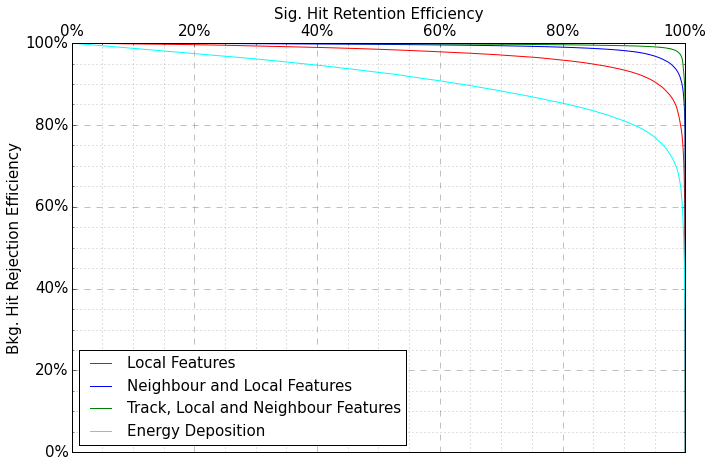

In [ ]:
plot_set_font()
figsize(11, 7.3333)
plot_rocs(test_cdc.get_measurement(test_cdc.hit_type_name,
                                   only_hits=True,
                                   flatten=True), 
         final_diagnostics.prediction, 
         zoom=False,
         datum_label="Hit")
plt.show()

In [ ]:
plot_set_font()
plot_rocs(test_cdc.get_measurement(test_cdc.hit_type_name,
                                   only_hits=True,
                                   flatten=True), 
         final_diagnostics.prediction, 
         zoom=True,
         datum_label="Hit")
plt.show()

In [ ]:
figsize(5.5, 7.3333/2.)

In [ ]:
labels = test_cdc.get_measurement(test_cdc.hit_type_name, 
                                  flatten=True)

In [ ]:
plot_feature( test_cdc.get_signal_hits()[test_cdc.time_name],
              test_cdc.get_background_hits()[test_cdc.time_name],
              xlabel="Detected time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Detected Time of Hits in CDC", 
              nbins=bins_for_plots)
show()

In [ ]:
plot_feature( test_cdc.get_signal_hits()[test_cdc.time_name] -\
              test_cdc.get_signal_hits()[drift_name],  
              test_cdc.get_background_hits()[test_cdc.time_name] -\
              test_cdc.get_background_hits()[drift_name], 
              xlabel="Truth time [ns]", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Truth Time of Hits in CDC", 
              nbins=bins_for_plots)
show()

In [ ]:
plot_feature(  test_cdc.get_measurement(rel_time_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=-1000)[labels == 1], 
               test_cdc.get_measurement(rel_time_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=-1000)[labels == 0], 
              xlabel="Relative Timing", ylabel="Normalised Hit Count", 
              title="Relative timing of Left Hand Wire, No Hit = -1000",
              xlog=False, nbins=bins_for_plots)
show()

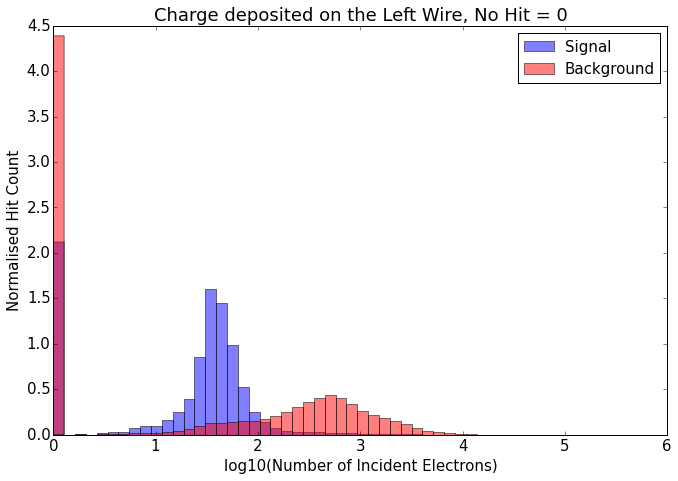

In [125]:
plot_feature(  np.log10(test_cdc.get_measurement(test_cdc.edep_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=1)[labels == 1]), 
               np.log10(test_cdc.get_measurement(test_cdc.edep_name, 
                                       flatten=True, 
                                       shift=-1, 
                                       default=1)[labels == 0]), 
              xlabel="log10(Number of Incident Electrons)", 
              ylabel="Normalised Hit Count", xlog=False,
              title="Charge deposited on the Left Wire, No Hit = 0", 
              nbins=bins_for_plots)
show()

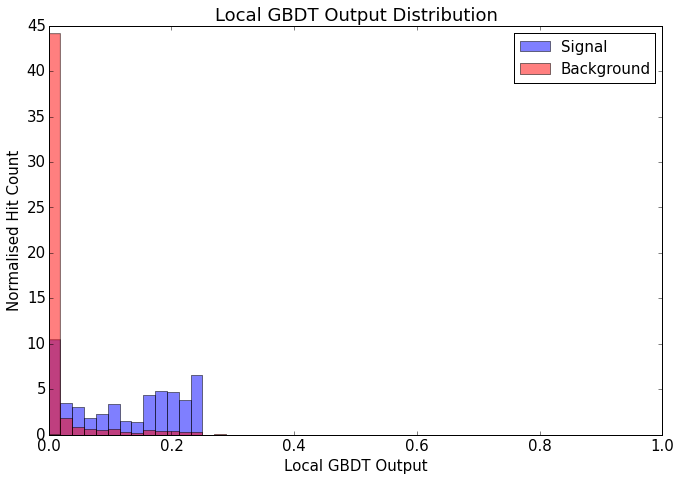

In [127]:
plot_feature( test_cdc.get_signal_hits()[lcl_scr_name], 
              test_cdc.get_background_hits()[lcl_scr_name],  
              xlabel="Local GBDT Output", ylabel="Normalised Hit Count", xlog=False,
              title="Local GBDT Output Distribution", nbins=bins_for_plots)
show()

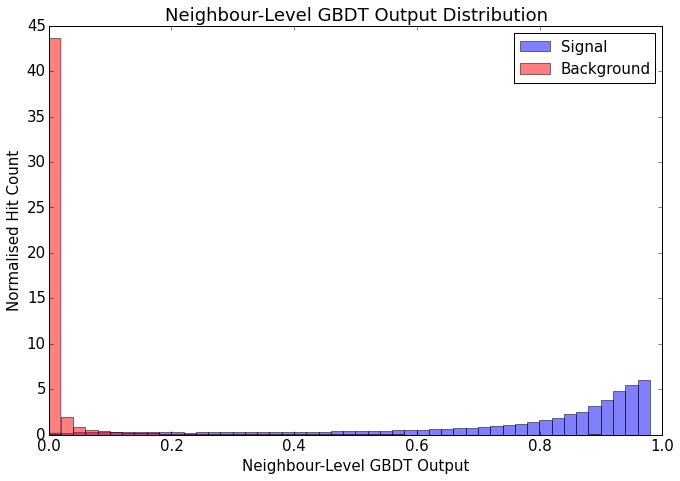

In [128]:
plot_feature( test_cdc.get_signal_hits()[ngh_scr_name], 
              test_cdc.get_background_hits()[ngh_scr_name], 
              xlabel="Neighbour-Level GBDT Output", ylabel="Normalised Hit Count", xlog=False,
              title="Neighbour-Level GBDT Output Distribution", nbins=bins_for_plots)
show()

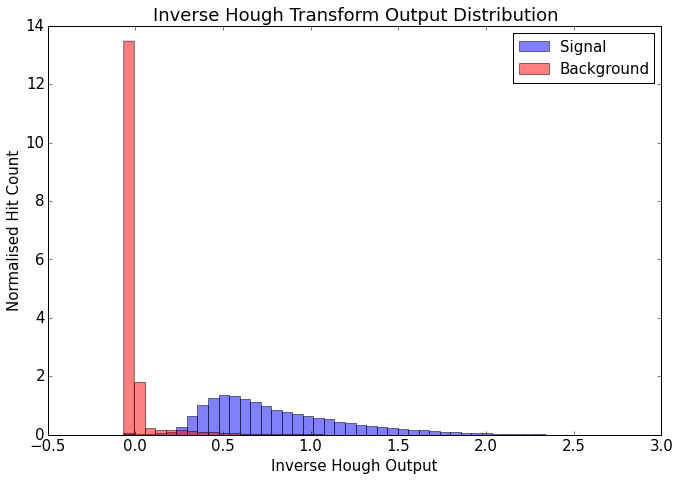

In [129]:
plot_feature( test_cdc.get_signal_hits()[hgh_scr_name], 
              test_cdc.get_background_hits()[hgh_scr_name], 
              xlabel="Inverse Hough Output", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Inverse Hough Transform Output Distribution", 
              nbins=bins_for_plots)
show()

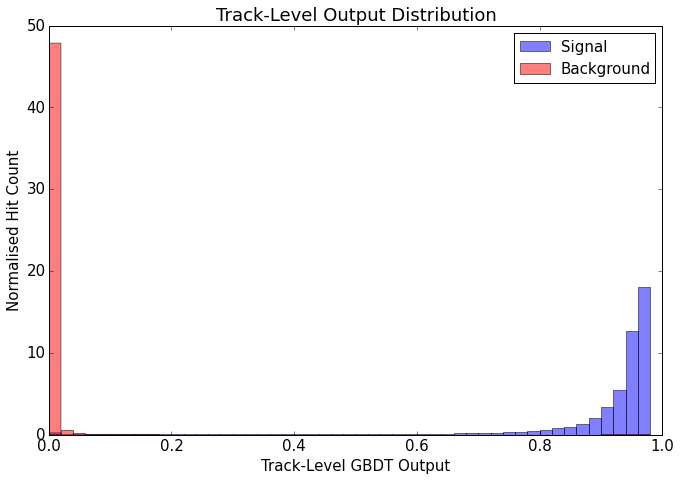

In [130]:
plot_feature( test_cdc.get_signal_hits()[trk_scr_name], 
              test_cdc.get_background_hits()[trk_scr_name],  
              xlabel="Track-Level GBDT Output", ylabel="Normalised Hit Count", 
              xlog=False,
              title="Track-Level Output Distribution", 
              nbins=bins_for_plots)
show()

In [131]:
# TODO clean this up
from collections import OrderedDict

#figsize(6.4,6.4) 
feat_label_dict = OrderedDict([
            (rel_time_name,               "Timing"),  
            (rel_time_name     +"_left",  "Left Timing"),  
            (rel_time_name     +"_right", "Right Timing"),  
            (test_cdc.edep_name,          "Charge"),  
            (test_cdc.edep_name+"_left",  "Left Charge"),  
            (test_cdc.edep_name+"_right", "Right Charge"),  
            (test_cdc.row_name,           "R Distance"),  
            (hgh_scr_name,               r"Hough, $W_j'$")
    ])

def plot_feature_importance(rep_classifier, feat_label_dict, font_size=None):
    feat_import = rep_classifier.get_feature_importances()
    feat_import = feat_import.sort("effect", ascending=True)
    ax = plt.subplot(111)
    ax.barh( np.arange(len(feat_import.values)), feat_import.values,zorder=10)
    ax.set_yticks(np.arange(len(feat_import.values))+0.5)
    ax.minorticks_on()
    ax.set_xlabel("Normalized Relative Usage")
    ax.set_title("Feature Importance")
    ax.autoscale()
    ax.grid(b=True, which='major', axis='x' ,color='grey', linestyle='--', lw=2)
    ax.grid(b=True, which='minor', axis='x' , color='grey', linestyle=':', lw=2)
    ordered_labels = OrderedDict((key, feat_label_dict[key]) for key in feat_import.index.values)
    ax.set_yticklabels(ordered_labels.values(), fontsize = font_size)
    #ax.set_xticks([tick for tick in ax.get_xticks()[::2]])
    ax.set_xticklabels(["{:.0f}%".format(tick*100) for tick in ax.get_xticks()], fontsize = font_size)
    return ax

def plot_feature_correlations(rep_factory, feat_label_dict, title="", font_size=None):
    corr = rep_factory.features_correlation_matrix(features=feat_label_dict.keys(),
                                tick_labels=feat_label_dict.values())
    corr.fontsize = font_size
    corr.cmap = "RdBu"
    return corr.plot(title=title)

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


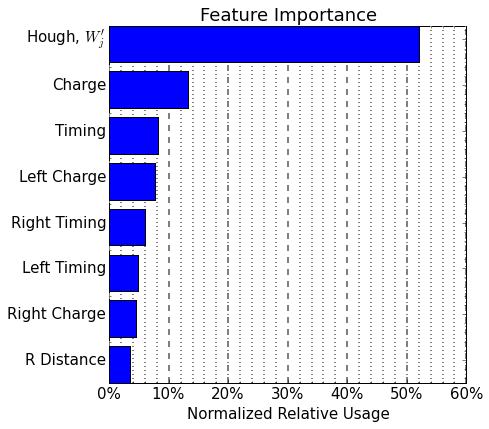

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


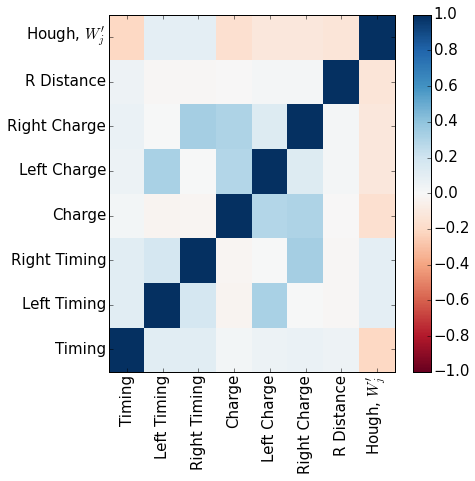

In [132]:
figsize(6.4,6.4) 
plot_feature_importance(hough_gbdt, feat_label_dict)
show()
plot_feature_correlations(final_diagnostics, feat_label_dict)
show()

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


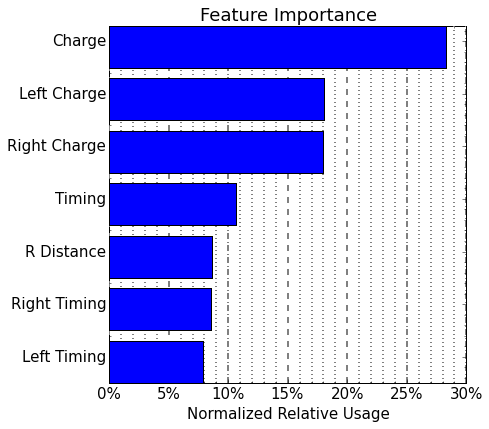

In [133]:
plot_feature_importance(neigh_gbdt, feat_label_dict)
show()

## Visualiaze the Data

In [134]:
high_hit = np.arange(test_cdc.n_events)[test_cdc.event_to_n_hits >= 600]
#high_hit = np.where(test_cdc.event_to_n_hits >= 800)[0]
n_sig = np.array([len(test_cdc.get_signal_hits(evt)) for evt in high_hit])
good_event = high_hit[np.logical_and(n_sig > 70, n_sig < 80)]
print len(good_event)
print good_event

98
[   4   36   66   77   81  155  251  258  275  300  314  333  384  415  449
  452  459  475  484  490  507  512  552  565  629  632  658  672  682  719
  722  863  881  884  899  911  927  945  988  990 1037 1065 1137 1183 1192
 1196 1199 1225 1273 1276 1293 1350 1351 1393 1403 1407 1408 1470 1491 1632
 1645 1662 1664 1686 1701 1749 1791 1812 1850 1874 1876 1883 1922 1940 1988
 2007 2061 2075 2082 2103 2143 2180 2208 2212 2232 2233 2234 2248 2267 2283
 2352 2356 2367 2397 2420 2433 2475 2478]


In [135]:
print hough_images.shape

(2499, 5654)


In [136]:
# Event information\
event = 8
event = good_event[event]
#event = evt_samp[3][event]
add_trans = True
save = True
savedir = "/vols/comet/users/elg112/ICEDUST/track-finding-yandex/review_meeting_plots/"

to_plot = np.take([0,2,1], test_cdc.get_measurement("CDCHit.fIsSig", 
                                   events=event, 
                                   default=-1, 
                                   only_hits=False,
                                   flatten=True).astype(int) + 1)
ngh_pred_size = plot_norm_size(test_cdc.get_measurement(ngh_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True))
trk_pred_size = plot_norm_size(test_cdc.get_measurement(trk_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True))
hough_output = test_cdc.get_measurement(hgh_scr_name, 
                                        events=event, 
                                        default=0, 
                                        only_hits=False,
                                        flatten=True)

#hough_event = evt_samp[3][event]
hough_event = event

plot_hough_image_3 = hough_images[hough_event,:hough.track.n_points] +\
                     hough_images[hough_event,hough.track.n_points:] 
plot_hough_no_rw = hough_transformer.normed_corresp.T.dot(ngh_pred_size.T).T
plot_hough_no_rw = plot_hough_no_rw[:hough.track.n_points] + plot_hough_no_rw[hough.track.n_points:]

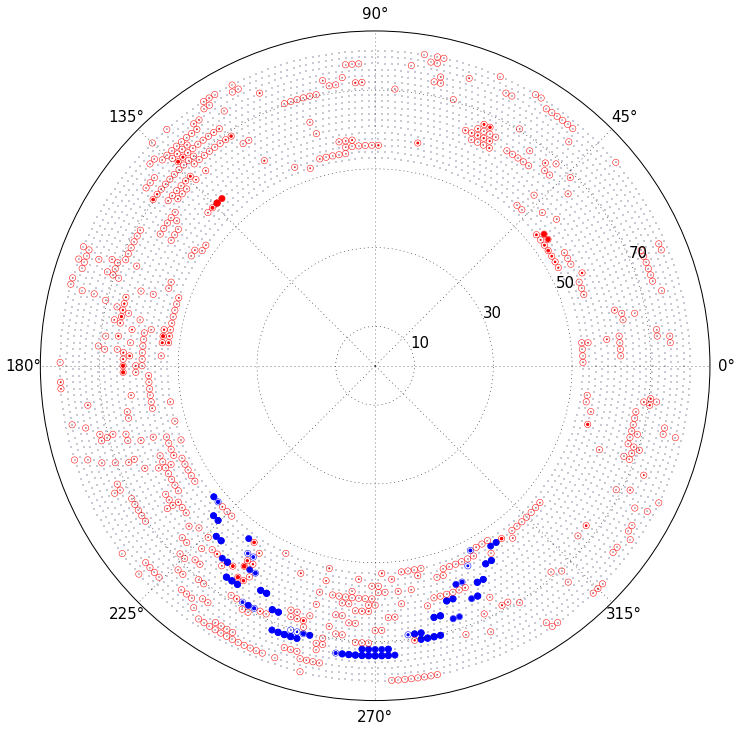

In [137]:
# First GBDT output
plot_output(to_plot, test_cdc.geom, 
            size=ngh_pred_size)
plot_add_outlines(to_plot, test_cdc.geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight')
show()


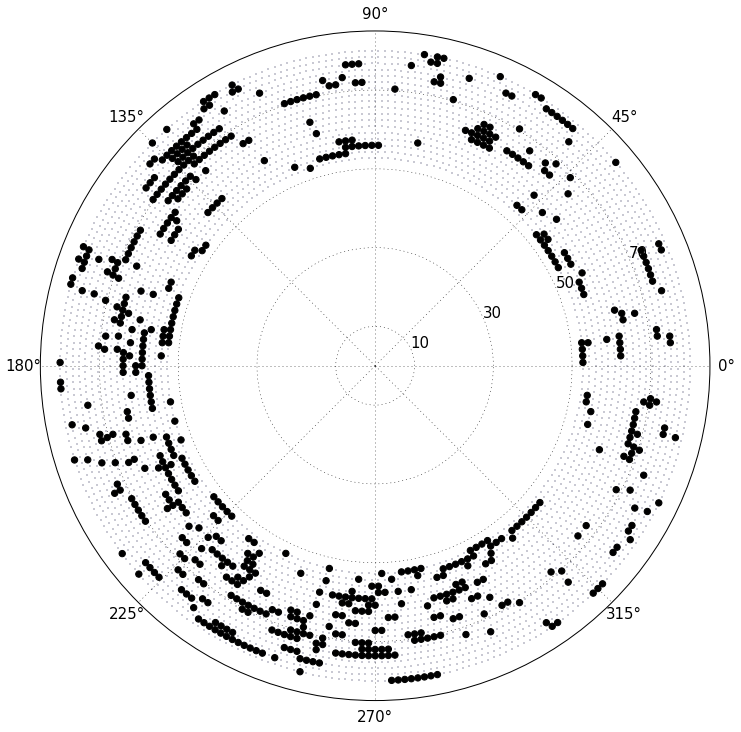

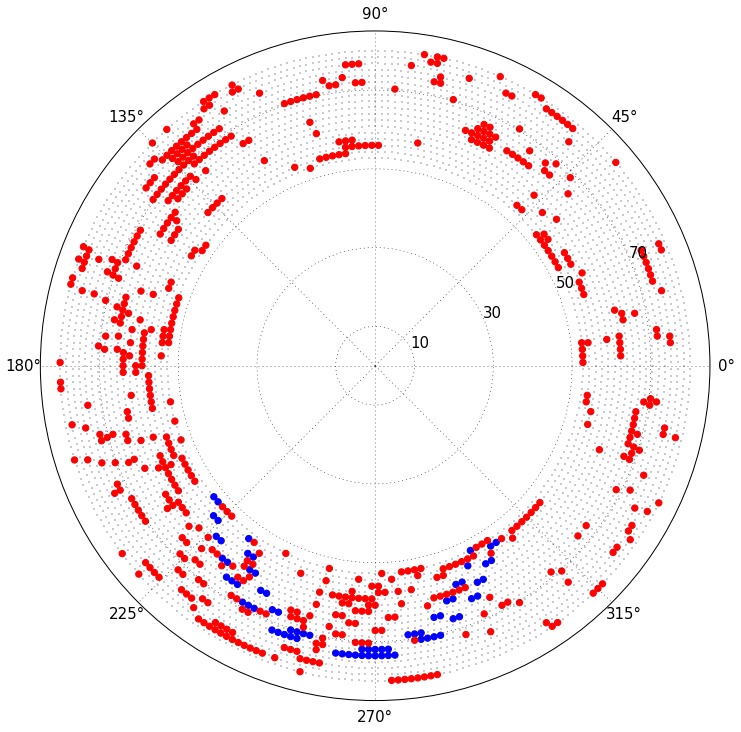

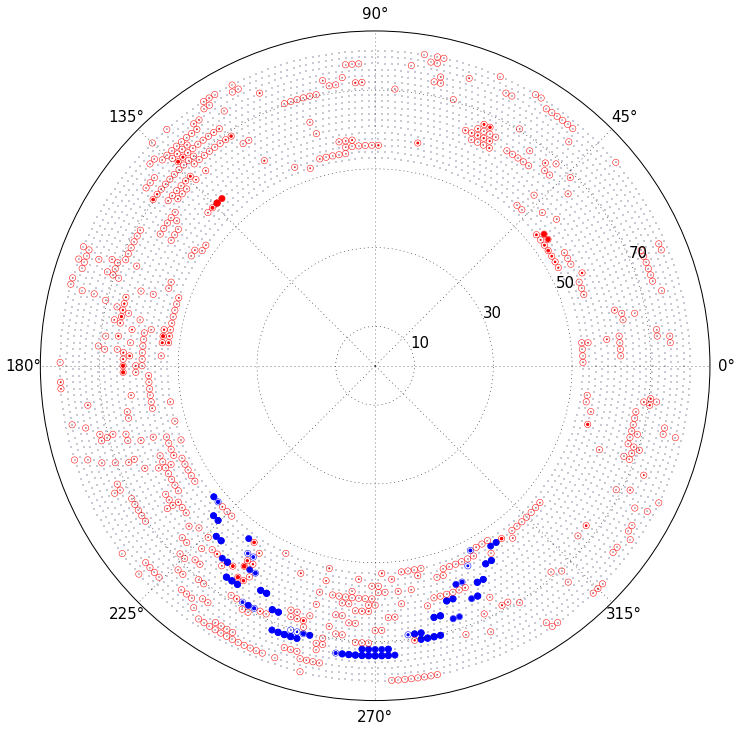

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Length of draw tracks are 2362


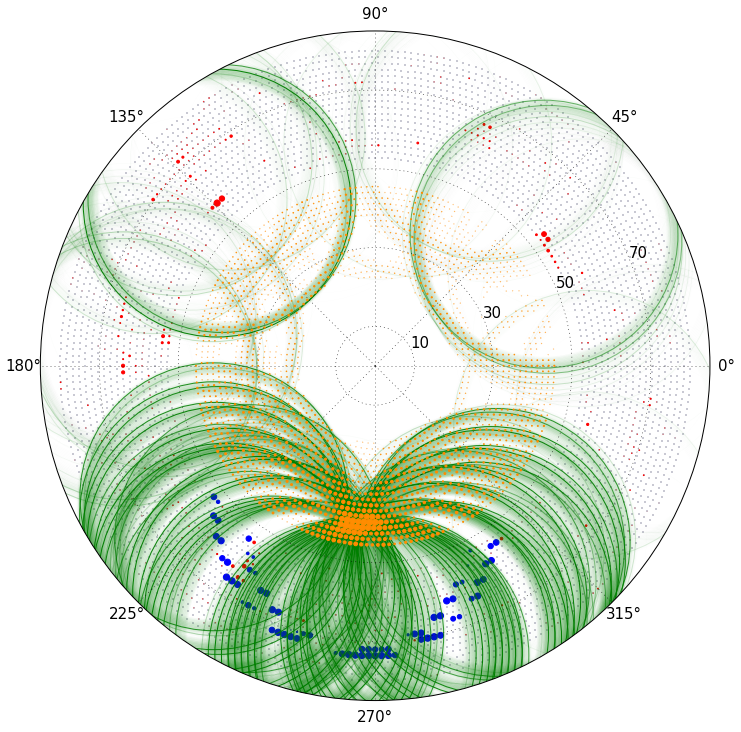

Length of draw tracks are 68


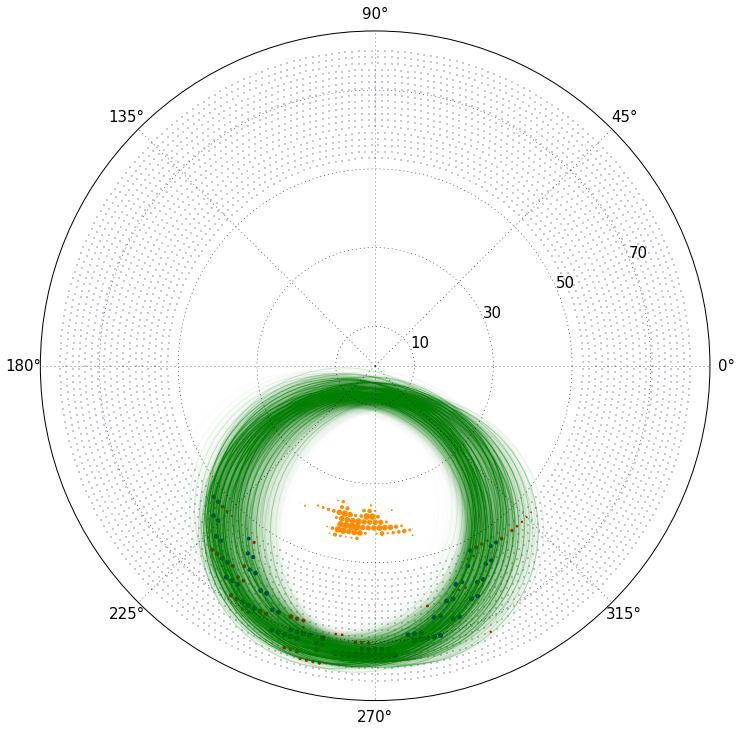

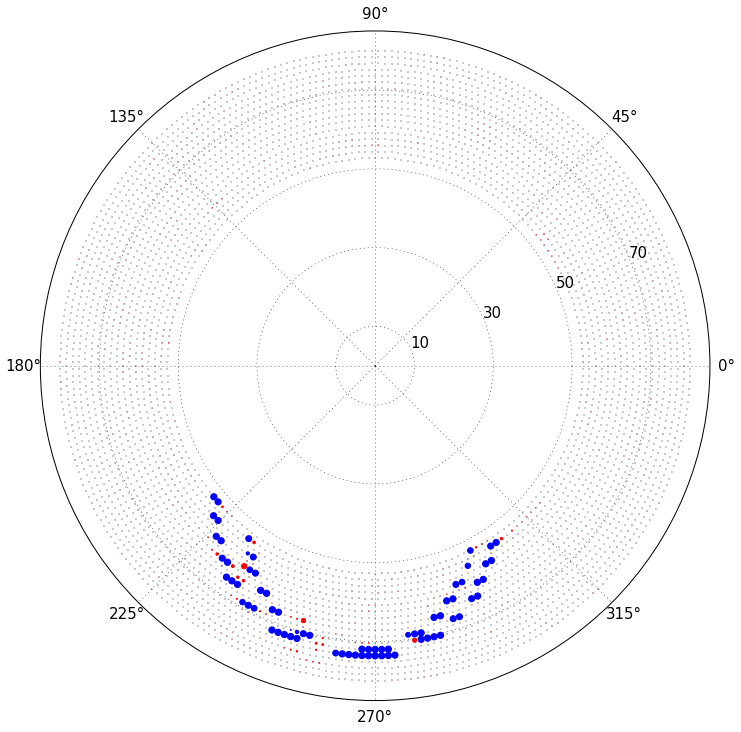

In [138]:
# Basic output
plot_output(to_plot, test_cdc.geom, sig_color='black', bkg_color='black', )
if save:
    plt.savefig(savedir+"plot_event_bw.png", bbox_inches='tight')
show()

plot_output(to_plot, test_cdc.geom)
if save:
    plt.savefig(savedir+"plot_event.png", bbox_inches='tight')
show()

# First GBDT output
plot_output(to_plot, test_cdc.geom, 
            size=ngh_pred_size)
plot_add_outlines(to_plot, test_cdc.geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight')
show()

# Hough output
plot_output(to_plot, test_cdc.geom, 
            size=ngh_pred_size, 
            add_transform=add_trans)
plot_add_tracks(test_cdc.geom, hough, 
                size=plot_norm_size(plot_hough_no_rw - np.amin(plot_hough_no_rw),40))
if save:
    plt.savefig(savedir+"plot_hough.png", bbox_inches='tight')
show()

# Inverse Hough output
plot_output(to_plot, test_cdc.geom, 
            size=plot_norm_size(hough_output))
plot_add_tracks(test_cdc.geom, hough, 
                size=plot_norm_size(plot_hough_image_3,40), 
                add_transform=add_trans,
                tolerance=0.00)
if save:
    plt.savefig(savedir+"plot_inv_hough.png", bbox_inches='tight')
show()    

# Final
plot_output(to_plot, test_cdc.geom, size=plot_norm_size(trk_pred_size))
if save:
    plt.savefig(savedir+"plot_final.png", bbox_inches='tight')
show()

In [144]:
from tabulate import tabulate

In [157]:
fpr, tpr, thresh = roc_curve(test_cdc.data["CDCHit.fIsSig"], 
          test_cdc.data[trk_scr_name])
def print_tpr_fpr(my_fpr, my_tpr, my_thresh, 
                  threshold_min=80, threshold_max=100, 
                  bins=100., steps=1,
                  filename=None):
    table = list()
    table.append([ "Bkg Retained", "Sig Retained", 'Threshold'])
    for this_thresh in np.arange(threshold_min,threshold_max, steps)[::-1]/float(bins):
        table.append([1. - this_thresh, my_tpr[my_fpr < 1. - this_thresh][-1], thresh[fpr < 1. - this_thresh][-1]])
    print tabulate(table, headers="firstrow")
print_tpr_fpr(fpr, tpr, thresh, threshold_min=80, threshold_max=100, bins=100)
print_tpr_fpr(fpr, tpr, thresh, threshold_min=900, threshold_max=1000, bins=1000, steps=1)

  Bkg Retained    Sig Retained    Threshold
--------------  --------------  -----------
          0.01        0.95671   0.621715
          0.02        0.986279  0.14356
          0.03        0.992692  0.0479495
          0.04        0.995053  0.024417
          0.05        0.996093  0.0135666
          0.06        0.996664  0.00768115
          0.07        0.997279  0.00481203
          0.08        0.997866  0.00356158
          0.09        0.998367  0.00287041
          0.1         0.998798  0.00230283
          0.11        0.999046  0.00195493
          0.12        0.999224  0.00172107
          0.13        0.999369  0.00152771
          0.14        0.999477  0.00138248
          0.15        0.999623  0.001255
          0.16        0.999677  0.00116639
          0.17        0.999709  0.00108471
          0.18        0.999752  0.000999206
          0.19        0.999801  0.000929862
          0.2         0.999828  0.000878771
  Bkg Retained    Sig Retained    Threshold
--------------  

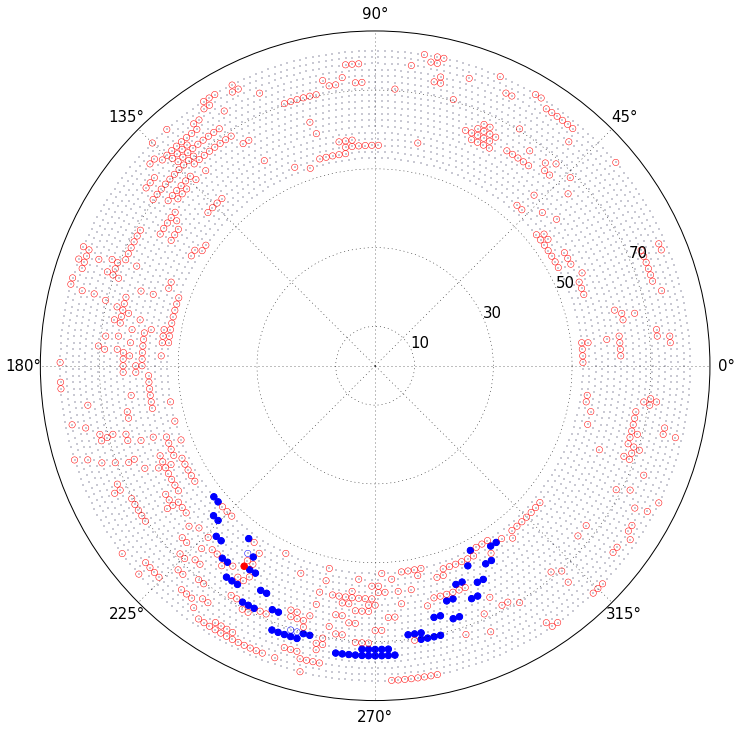

In [165]:
# Final
plot_output(to_plot, test_cdc.geom, size=plot_norm_size(test_cdc.get_measurement(trk_scr_name, 
                                                        events=event, 
                                                        default=0, 
                                                        only_hits=False,
                                                        flatten=True) > 0.49132))
plot_add_outlines(to_plot, test_cdc.geom)
if save:
    plt.savefig(savedir+"plot_final.png", bbox_inches='tight')
show()

## Export the Data

In [ ]:
export_name = "track_finding_sample_scored_2.root"

In [ ]:
test_cdc.trim_hits(test_cdc.hits_index_name, 
                   values=test_cdc.data[hit_masks[3]][test_cdc.hits_index_name])

In [ ]:
from rootpy.tree import Tree, TreeModel, FloatCol, IntCol
from rootpy.io import root_open
from rootpy.vector import LorentzVector
from rootpy import stl
from random import gauss, randint

# Map from python types to c++ types
type_dict = {dtype('float64'):"double", 
             dtype('int32')  :"long",
             dtype('int64')  :"long"}

# Define the model of the output root file
class CDCTree(TreeModel):
    # Create a std::vector branch for each measurement
    for measure in test_cdc.data.dtype.names:
        this_dtype = type_dict[test_cdc.data.dtype[measure]]
        measure = measure.replace(".", "_")
        exec(measure + " = stl.vector(this_dtype)")
    # Delete branches we do not want
    del measure, this_dtype

# Open the output file
with root_open(savedir+export_name, mode='recreate') as output_file:
    # Open a new tree
    output_tree = Tree("test", model=CDCTree)
    for event in range(test_cdc.n_events):
        if event%100 == 0:
            print event
        event_hits = test_cdc.get_events(event)
        for measure in event_hits.dtype.names:
            this_measure = event_hits[measure]
            for hit_val in this_measure:
                output_tree[measure.replace(".","_")].push_back(hit_val)
        output_tree.fill(reset=True)
    output_tree.write()

In [ ]:
fpr, tpr, thresh = roc_curve(test_cdc.data["CDCHit.fIsSig"], 
          test_cdc.data[trk_scr_name])

In [ ]:
def print_tpr_fpr(my_fpr, my_tpr, my_thresh, 
                  threshold_min=80, threshold_max=100, 
                  bins=100., steps=1,
                  filename=None):
    table = list()
    table.append([ "Bkg Retained", "Sig Retained", 'Threshold'])
    for this_thresh in np.arange(threshold_min,threshold_max, steps)[::-1]/float(bins):
        table.append([1. - this_thresh, my_tpr[my_fpr < 1. - this_thresh][-1], thresh[fpr < 1. - this_thresh][-1]])
    print tabulate(table, headers="firstrow")

In [ ]:
print_tpr_fpr(fpr, tpr, thresh, threshold_min=80, threshold_max=100, bins=100)
print_tpr_fpr(fpr, tpr, thresh, threshold_min=900, threshold_max=1000, bins=1000, steps=5)

In [ ]:
# TODO 
# Plots for Louis

# Penalize for not being the closest point to the fit



# Belle-II literature
# multiple radii
# optimize hough to improve track purity, use RANSAC to shed background islands
# 

#TODO Offline Analysis
# THURS penalize on no hits for RANSAC
# THURS change sampling probability via GBDT score
# THURS change scoring weight by GBDT score
# FRI check results for mulitple radii, no optimization
# FRI check results for varying hit efficiencies, no optimization


# In[73]:

#TODO Online
# TUES Integrate trigger signal in


# In[75]:

# NOTES
## Shifting to align image in hough space must 
#  play well with the placticity already 
#  implimented in the algorithm.  Adjust reweighting
## Try reweighting background hits close to signal hits
#  as worse when we do the track level GBDT algo.  Rid
#  background islands at RANSAC level.